In [18]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns

In [19]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    runs_on_gpu = True
else:
    device = torch.device('cpu')
    runs_on_gpu = False
print(f"Runs on {device.type}")

Runs on cpu


In [20]:
data = pd.read_json('preprocessed_recipes.json')
data.info()

(10608, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20100 entries, 0 to 20099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   directions   20100 non-null  object             
 1   fat          15901 non-null  float64            
 2   date         20100 non-null  datetime64[ns, UTC]
 3   categories   20100 non-null  object             
 4   calories     15969 non-null  float64            
 5   desc         13484 non-null  object             
 6   protein      15922 non-null  float64            
 7   rating       20100 non-null  float64            
 8   title        20100 non-null  object             
 9   ingredients  20100 non-null  object             
 10  sodium       15967 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(5), object(5)
memory usage: 1.7+ MB


In [21]:
data.head()

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.0
3,[Heat oil in heavy large skillet over medium-h...,NaN,2009-03-27 04:00:00+00:00,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",NaN,The Sicilian-style tomato sauce has tons of Me...,NaN,5.000,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c...",NaN
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.0


In [22]:
mandatory_columns = ['directions', 'date', 'categories', 'title', 'ingredients']
optional_columns = ['fat', 'calories', 'desc', 'protein', 'sodium']
numerical_columns = ['fat', 'calories', 'protein', 'sodium']
textual_columns = ['title', 'directions', 'desc']

<Axes: xlabel='rating'>

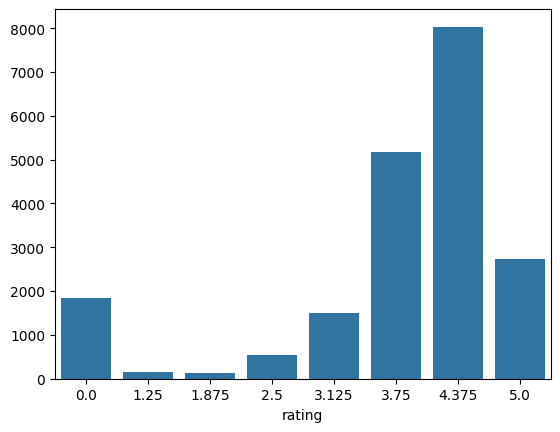

In [23]:
ratings = data['rating']
data.drop(columns=['rating'])
rating_value_counts = ratings.value_counts()
sns.barplot(x=rating_value_counts.index, y=rating_value_counts.values)

# 3 Basic Project
The basic project will consist of solving a regression task, comparing the performance obtained using different vectorizations of the documents and at least two different machine learning strategies, as described below. 

You should use the information in the directions and/or desc variables for all steps of the project, possibly combining this information with metadata from other variables. You should use appropriate metrics for evaluating this task. The performance of the different methods should be estimated using a validation methodology, which you should also explain in the documentation. You should provide a description of the methodology used and analyze the performance obtained according to the input variables.
Keep in mind that the goal is to describe the work carried out and critically analyze the results obtained. Support this with graphs or other representations you consider appropriate. There is no need to describe the algorithms used, but you should explain how you tuned their parameters.

## Baseline

In [20]:
mean_rating = np.mean(data['rating'])
baseline_mse = np.mean((data['rating'] - mean_rating)**2)
print(f"Mean rating: {mean_rating} and MSE: {baseline_mse}")

Mean rating: 3.7130597014925373 and MSE: 1.8039448048934432


In [21]:
most_used_rating = 4.375
mse = np.mean((data['rating'] - most_used_rating)**2)
print(f"MSE: {mse}")

MSE: 2.242109763681592


## 3.4
Training and evaluation of regression models using at least the following two machine learning strategies:
- Neural networks using PyTorch for implementation.
- At least one other technique implemented in the Scikit-learn library
(e.g., K-NN, SVM, Random Forest, etc.)

### Neural networks using PyTorch for implementation.

In [4]:
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [114]:
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, int(input_size/2))
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(int(input_size/2), 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 128)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x       

In [118]:
#embeddings = pd.read_hdf('local_store.h5', key='tfidf').to_numpy()
#embeddings = pd.read_hdf('local_store.h5', key='word2vec').to_numpy()
embeddings = np.load("context_embedding.npy")
embeddings = embeddings.reshape(embeddings.shape[0], -1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(embeddings, ratings.to_numpy(), test_size=0.2, random_state=42)

Training Matrix:  torch.Size([16080, 2304]) torch.Size([16080, 1])
Test Matrix:  (4020, 2304)
input_size:  2304
Epoch [1/100], Loss: 15.6339
Epoch [11/100], Loss: 2.1760
Epoch [21/100], Loss: 1.8882
Epoch [31/100], Loss: 1.7643
Epoch [41/100], Loss: 1.6725
Epoch [51/100], Loss: 1.6269
Epoch [61/100], Loss: 1.5968
Epoch [71/100], Loss: 1.5773
Epoch [81/100], Loss: 1.5627
Epoch [91/100], Loss: 1.5476
Epoch [100/100], Loss: 1.5336
Test Loss: 1.6349
Compared to baseline mse: 110%


In [ ]:

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
y_train_tensor = y_train_tensor.unsqueeze(1)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)
y_test_tensor = y_test_tensor.unsqueeze(1)

print('Training Matrix: ', X_train_tensor.shape, y_train_tensor.shape)
print('Test Matrix: ', X_test.shape)
 
input_size = X_train.shape[1]
print('input_size: ', input_size)

model = RegressionModel(input_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(num_epochs):
    outputs = model(X_train_tensor)
    
    loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch % 10 == 0):
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

with torch.no_grad():
    model.eval()
    test_outputs = torch.round(model(X_test_tensor))
    
test_loss = criterion(test_outputs, y_test_tensor)
print(f'Test Loss: {test_loss.item():.4f}')
print(f"Compared to baseline mse: {baseline_mse / test_loss * 100:.0f}%")

### - At least one other technique implemented in the Scikit-learn library
(e.g., K-NN, SVM, Random Forest, etc.)

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [122]:
from sklearn.ensemble import RandomForestRegressor

In [123]:
rf_x = data[numerical_columns].copy()
rf_x['rating'] = data['rating']
rf_x.dropna(how='any', inplace=True)
rf_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15896 entries, 0 to 20099
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fat       15896 non-null  float64
 1   calories  15896 non-null  float64
 2   protein   15896 non-null  float64
 3   sodium    15896 non-null  float64
 4   rating    15896 non-null  float64
dtypes: float64(5)
memory usage: 745.1 KB


In [124]:
X_train, X_test, y_train, y_test = train_test_split(rf_x[numerical_columns], rf_x['rating'], test_size=0.2, random_state=42)

In [125]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)

RandomForestRegressor()

In [126]:
y_pred = rf_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)

mean_error = np.mean(np.abs(y_test - y_pred))
print(mean_error)

score = rf_regressor.score(X_test, y_test)
print(score)

print(f"Compared to baseline mse: {baseline_mse / mse * 100:.0f}%")

1.4590357331597468
0.7948702971569578
0.1424960712118577
Compared to baseline mse: 124%


## 3.5
Comparison of the results obtained in step 3 with fine-tuning a pre-trained model from Hugging Face. In this step, you are asked to use a transformer model with a regression head.

In [11]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split  

In [28]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
X = data['directions'].tolist()
y = ratings.to_numpy(dtype='float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=128)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, y_train)
test_dataset = Dataset(test_encodings, y_test)

model.to(device)

training_args = TrainingArguments(
    output_dir='./results', # Output directory
    num_train_epochs=3, # Number of epochs
    per_device_train_batch_size=16, # Training batch size
    per_device_eval_batch_size=64, # Evaluation batch size
    warmup_steps=500, # Warmup steps
    weight_decay=0.01, # Weight decay
    logging_dir='./logs', # Logging directory
    logging_steps=10,
)

trainer = Trainer(
    model=model, # Pre-trained model
    args=training_args, # Training arguments
    train_dataset=train_dataset, # Training data
    eval_dataset=test_dataset # Evaluation data
)

print("Start training")

# Start fine-tuning
trainer.train()

# Evaluate the model
trainer.evaluate()

# Save the fine-tuned model
model.save_pretrained('./fine-tuned-bert')
tokenizer.save_pretrained('./fine-tuned-bert')

Start training


                                        
  0%|          | 0/3015 [05:41<?, ?it/s]         

{'loss': 13.6354, 'grad_norm': 110.56185913085938, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}


                                        
  0%|          | 0/3015 [05:44<?, ?it/s]         

{'loss': 12.4936, 'grad_norm': 127.78746032714844, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.02}


                                        
  0%|          | 0/3015 [05:48<?, ?it/s]         

{'loss': 10.6723, 'grad_norm': 95.80782318115234, 'learning_rate': 3e-06, 'epoch': 0.03}


                                        
  0%|          | 0/3015 [05:51<?, ?it/s]         

{'loss': 8.7736, 'grad_norm': 114.6506118774414, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.04}


                                        
  0%|          | 0/3015 [05:55<?, ?it/s]         

{'loss': 7.0099, 'grad_norm': 84.49993896484375, 'learning_rate': 5e-06, 'epoch': 0.05}


KeyboardInterrupt: 